## Load test-valid-train data

Define some columns we use a lot

In [1]:
household_id = 'idhogar'
target_column = 'Target'

Load data into pandas dataframes

In [2]:
from data_cleaning import get_training_data, get_test_data
train = get_training_data()
test = get_test_data()

/home/minnie/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/minnie/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Loading data from data/train.csv...
(9557, 142)

Checking for inconsistent targets...
(85,)
(9557, 142)
Cleaning inconsistent targets...
Checking inconsistent targets are gone...
(0,)
(9557, 142)

Loading data from data/test.csv...
(23856, 141)



Select subset of data - only features refering to physical building

In [3]:
from column_categories import building_info
building_columns = [household_id]
building_columns.extend(building_info)
building_df = train[building_columns]

In [4]:
from data_cleaning import get_column_dtypes
get_column_dtypes(building_df)

{'int64': Index(['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad',
        'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisocemento',
        'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera', 'techozinc',
        'techoentrepiso', 'techocane', 'techootro', 'cielorazo',
        'abastaguadentro', 'abastaguafuera', 'abastaguano', 'public', 'planpri',
        'noelec', 'coopele', 'sanitario1', 'sanitario2', 'sanitario3',
        'sanitario5', 'sanitario6', 'energcocinar1', 'energcocinar2',
        'energcocinar3', 'energcocinar4', 'elimbasu1', 'elimbasu2', 'elimbasu3',
        'elimbasu4', 'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
        'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3'],
       dtype='object'), 'object': Index(['idhogar'], dtype='object')}

Reduce data from individual breakdown to household level breakdown

In [5]:
from data_cleaning import target_by_household
target_household_map = target_by_household(train)
building_df = building_df.groupby(household_id).any().astype(int)
building_df = building_df.join(target_household_map)

## Look at building features across classes

### Util functions

In [6]:
import seaborn as sns
sns.set()

In [7]:
from column_categories import column_descriptions

In [8]:
def proportions(df):
    for col in df:
        df[col] =  df[col]/df[col].sum()
    return df

In [9]:
def get_columns_about(incl_value, excl_value, string_replacements):
    descriptions = {k: column_descriptions[k] for k in building_columns \
                    if incl_value in column_descriptions[k] \
                    and excl_value not in column_descriptions[k]}
    for r, s in string_replacements.items():
        descriptions = dict(map(
            lambda kv: (kv[0], kv[1].replace(r,s)), descriptions.items()
        ))
    return descriptions

In [10]:
def plot_breakdowns(desc):
    df = building_df[list(desc.keys())].join(target_household_map)
    if len(desc)==1:
        value = list(desc.keys())[0]
        desc['no '+value] = ''
        df['no '+value] = (~df[value].astype('bool')).astype('int')
    summed = df.groupby(target_column).sum()
    features_breakdown = proportions(summed.T).T
    features_breakdown.rename(columns=lambda x: ' : '.join([x, desc.get(x)]), inplace=True)
    features_breakdown.plot(kind='bar', stacked=True, figsize=(12,6)) \
    .legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size':14})
    return features_breakdown

### Floors

In [11]:
desc = get_columns_about('floor', 'are', {'=1 if predominant material on the floor is ':'',
                                         '=1 if no floor at the household':'no floor',
                                         '"':''})
desc

{'pisomoscer': 'mosaic,  ceramic,  terrazo',
 'pisocemento': 'cement',
 'pisoother': 'other',
 'pisonatur': ' natural material',
 'pisonotiene': 'no floor',
 'pisomadera': 'wood'}

,"pisomoscer : mosaic, ceramic, terrazo",pisocemento : cement,pisoother : other,pisonatur : natural material,pisonotiene : no floor,pisomadera : wood
Target,,,,,,
1,0.454955,0.400901,0.000000,0.004505,0.036036,0.103604
2,0.511312,0.332579,0.000000,0.004525,0.036199,0.115385
3,0.626016,0.271003,0.000000,0.000000,0.018970,0.084011
4,0.793350,0.154476,0.001023,0.000000,0.004092,0.047059


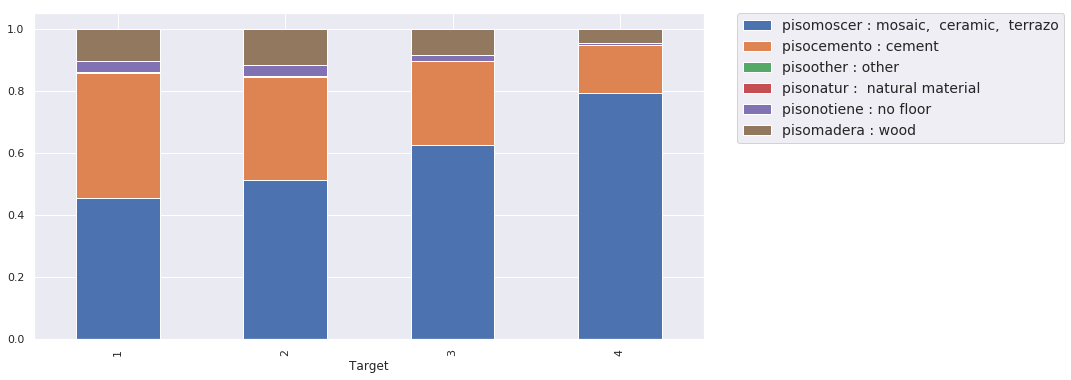

In [12]:
plot_breakdowns(desc)

 - There is no siginificant difference between `pisomoscer` and `pisocemento` for households at the lower end of the scale. (Mosaic, ceramin, terrazo, cement all equally present)
 - `pisoother` is only present for the richest households (Other material)
 - `pisonatur` is never present for the two richer households (natural material)
 - `pisonotiene` is rare for richest households (no floor)

### Outer walls

In [13]:
desc = get_columns_about('outside wall', 'blah', {'=1 if predominant material on the outside wall is ':'', '"':''})
desc

{'paredblolad': 'block or brick',
 'paredzocalo': 'socket (wood,  zinc or absbesto',
 'paredpreb': 'prefabricated or cement',
 'pareddes': 'waste material',
 'paredmad': 'wood',
 'paredzinc': 'zink',
 'paredfibras': 'natural fibers',
 'paredother': 'other'}

,paredblolad : block or brick,"paredzocalo : socket (wood, zinc or absbesto",paredpreb : prefabricated or cement,pareddes : waste material,paredmad : wood,paredzinc : zink,paredfibras : natural fibers,paredother : other
Target,,,,,,,,
1,0.378378,0.108108,0.261261,0.027027,0.198198,0.018018,0.009009,0.000000
2,0.395928,0.122172,0.237557,0.022624,0.196833,0.020362,0.002262,0.002262
3,0.514905,0.081301,0.238482,0.010840,0.151762,0.002710,0.000000,0.000000
4,0.692072,0.063427,0.152430,0.002558,0.078772,0.008184,0.001023,0.001535


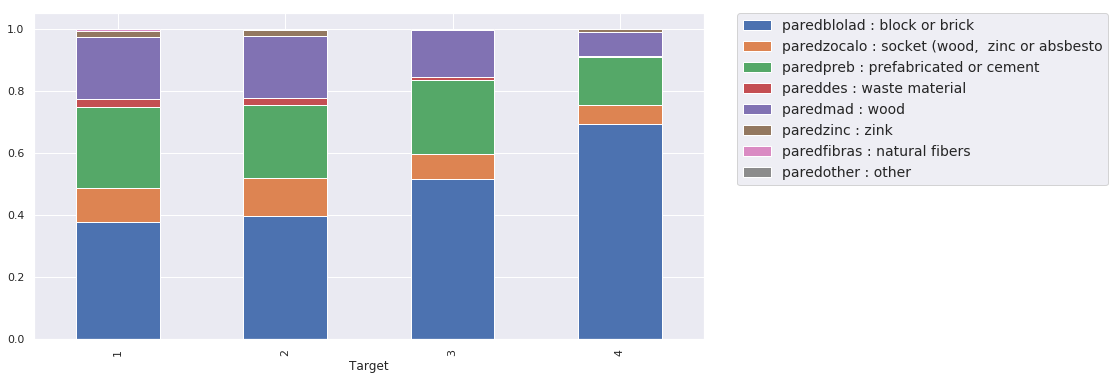

In [14]:
plot_breakdowns(desc)

### Roof

In [15]:
desc = get_columns_about('roof', 'are', {'=1 if predominant material on the roof is ':'', '"':''})
desc

{'techozinc': 'metal foil or zink',
 'techoentrepiso': 'fiber cement,  mezzanine ',
 'techocane': 'natural fibers',
 'techootro': 'other'}

,techozinc : metal foil or zink,"techoentrepiso : fiber cement, mezzanine",techocane : natural fibers,techootro : other
Target,,,,
1,0.972350,0.013825,0.013825,0.000000
2,0.981524,0.018476,0.000000,0.000000
3,0.991848,0.005435,0.002717,0.000000
4,0.967709,0.026140,0.002563,0.003588


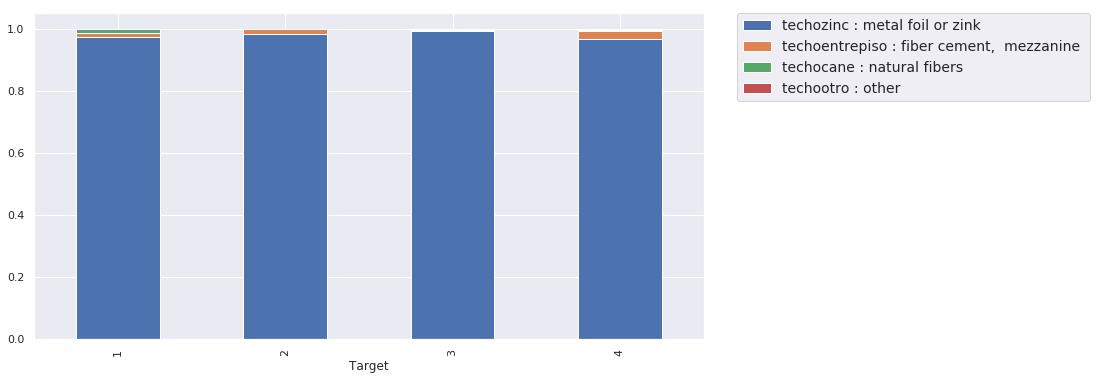

In [16]:
plot_breakdowns(desc)

### Ceiling

There's only one column here - we're not measuring the presence of this against any other class in a one-hot encoded array. Needs to be handled differently

In [17]:
desc = get_columns_about('ceiling', 'blah', {'=1 if the ':''})
desc

{'cielorazo': 'house has ceiling'}

,cielorazo : house has ceiling,no cielorazo :
Target,,
1,0.423423,0.576577
2,0.484163,0.515837
3,0.574526,0.425474
4,0.788235,0.211765


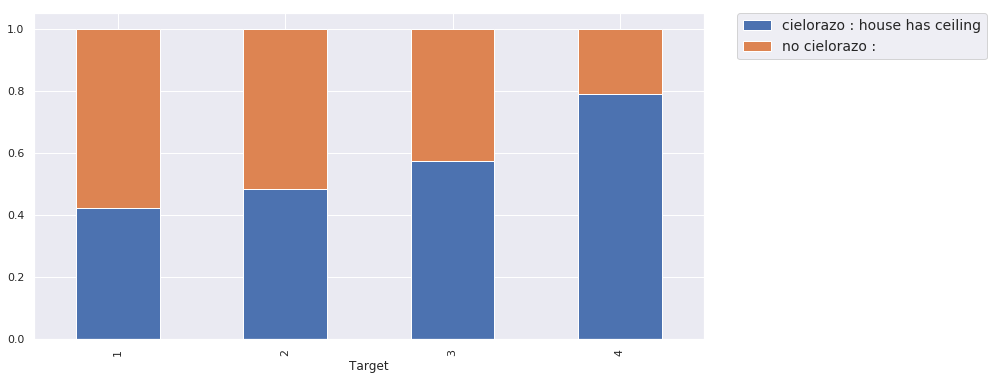

In [18]:
plot_breakdowns(desc)

### Water

In [19]:
desc = get_columns_about('water', 'blah', {'=1 if ':''})
desc

{'abastaguadentro': 'water provision inside the dwelling',
 'abastaguafuera': 'water provision outside the dwelling',
 'abastaguano': 'no water provision'}

,abastaguadentro : water provision inside the dwelling,abastaguafuera : water provision outside the dwelling,abastaguano : no water provision
Target,,,
1,0.954955,0.040541,0.004505
2,0.941176,0.045249,0.013575
3,0.964770,0.029810,0.005420
4,0.975448,0.023529,0.001023


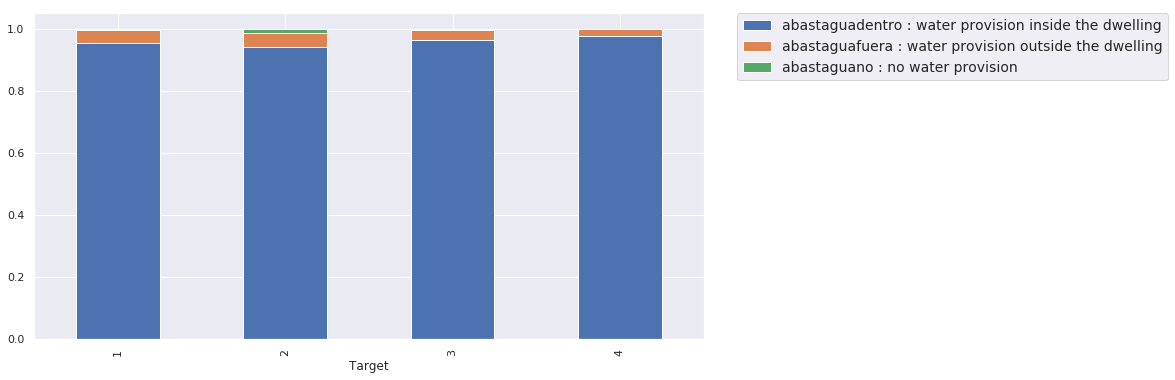

In [20]:
plot_breakdowns(desc)

### Electricity

In [21]:
desc = get_columns_about('electricity', 'cooking', {'=1 if ':'','"':'','  ':' '})
desc

{'public': '=1 electricity from CNFL, ICE, ESPH/JASEC',
 'planpri': '=1 electricity from private plant',
 'noelec': '=1 no electricity in the dwelling',
 'coopele': '=1 electricity from cooperative'}

,"public : =1 electricity from CNFL, ICE, ESPH/JASEC",planpri : =1 electricity from private plant,noelec : =1 no electricity in the dwelling,coopele : =1 electricity from cooperative
Target,,,,
1,0.886878,0.000000,0.009050,0.104072
2,0.875000,0.002273,0.009091,0.113636
3,0.869919,0.000000,0.000000,0.130081
4,0.893040,0.000512,0.001535,0.104913


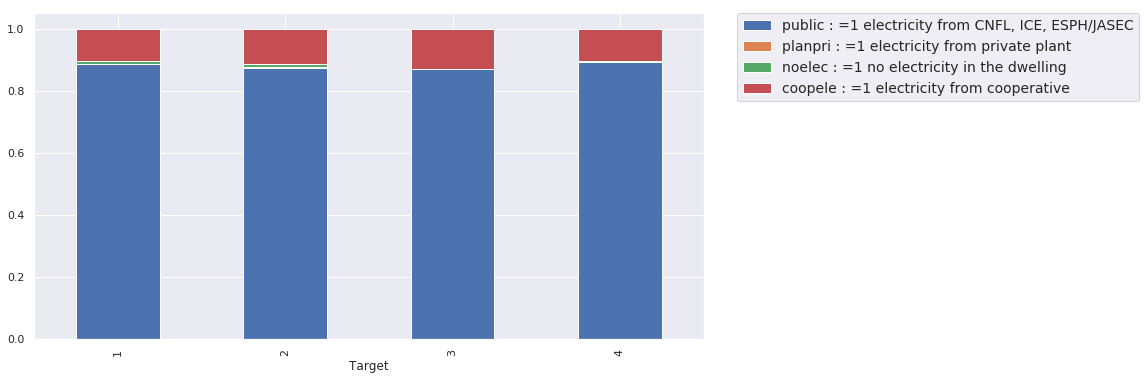

In [22]:
plot_breakdowns(desc)

### Toilet

In [23]:
desc = get_columns_about('toilet', 'blah', {'=1 ':'','"':'','  ':' '})
desc
# del desc['sanitario3']
# del desc['sanitario2']

{'sanitario1': 'no toilet in the dwelling',
 'sanitario2': 'toilet connected to sewer or cesspool',
 'sanitario3': 'toilet connected to septic tank',
 'sanitario5': 'toilet connected to black hole or letrine',
 'sanitario6': 'toilet connected to other system'}

,sanitario1 : no toilet in the dwelling,sanitario2 : toilet connected to sewer or cesspool,sanitario3 : toilet connected to septic tank,sanitario5 : toilet connected to black hole or letrine,sanitario6 : toilet connected to other system
Target,,,,,
1,0.013514,0.148649,0.797297,0.036036,0.004505
2,0.009050,0.176471,0.787330,0.022624,0.004525
3,0.008130,0.146341,0.821138,0.024390,0.000000
4,0.002558,0.257801,0.731458,0.006138,0.002046


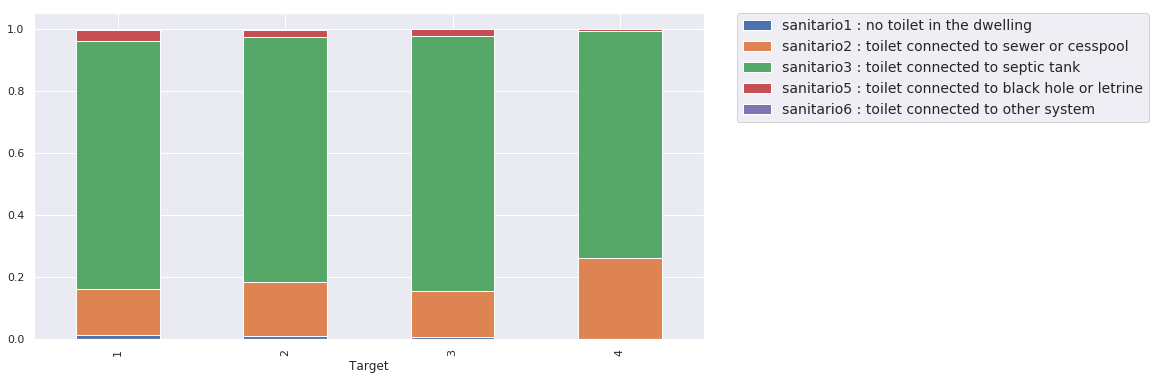

In [24]:
plot_breakdowns(desc)

### Cooking

In [25]:
desc = get_columns_about('cooking', 'blah', {'=1 ':'', 'main source of energy used for cooking ':''})
desc

{'energcocinar1': 'no (no kitchen)',
 'energcocinar2': 'electricity',
 'energcocinar3': 'gas',
 'energcocinar4': 'wood charcoal'}

,energcocinar1 : no (no kitchen),energcocinar2 : electricity,energcocinar3 : gas,energcocinar4 : wood charcoal
Target,,,,
1,0.018018,0.342342,0.522523,0.117117
2,0.006787,0.386878,0.506787,0.099548
3,0.008130,0.439024,0.490515,0.062331
4,0.002558,0.560102,0.413811,0.023529


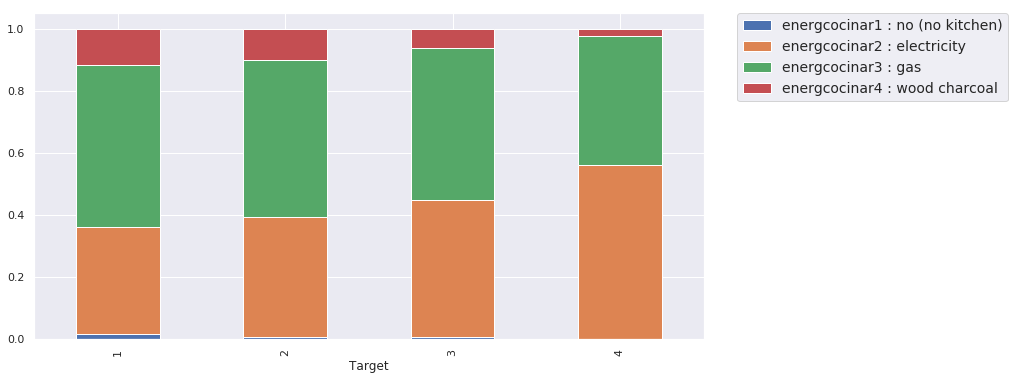

In [26]:
plot_breakdowns(desc)

### Rubbish disposal

In [27]:
desc = get_columns_about('rubbish disposal', 'blah', {'=1 ':'', '"':'', 'if rubbish disposal mainly ':''})
desc

{'elimbasu1': 'by tanker truck',
 'elimbasu2': 'by botan hollow or buried',
 'elimbasu3': 'by burning',
 'elimbasu4': 'by throwing in an unoccupied space',
 'elimbasu5': 'by throwing in river,  creek or sea',
 'elimbasu6': 'other'}

,elimbasu1 : by tanker truck,elimbasu2 : by botan hollow or buried,elimbasu3 : by burning,elimbasu4 : by throwing in an unoccupied space,"elimbasu5 : by throwing in river, creek or sea",elimbasu6 : other
Target,,,,,,
1,0.801802,0.040541,0.157658,0.000000,0.0,0.000000
2,0.796380,0.054299,0.142534,0.006787,0.0,0.000000
3,0.837398,0.035230,0.121951,0.005420,0.0,0.000000
4,0.920716,0.022506,0.054731,0.000000,0.0,0.002046


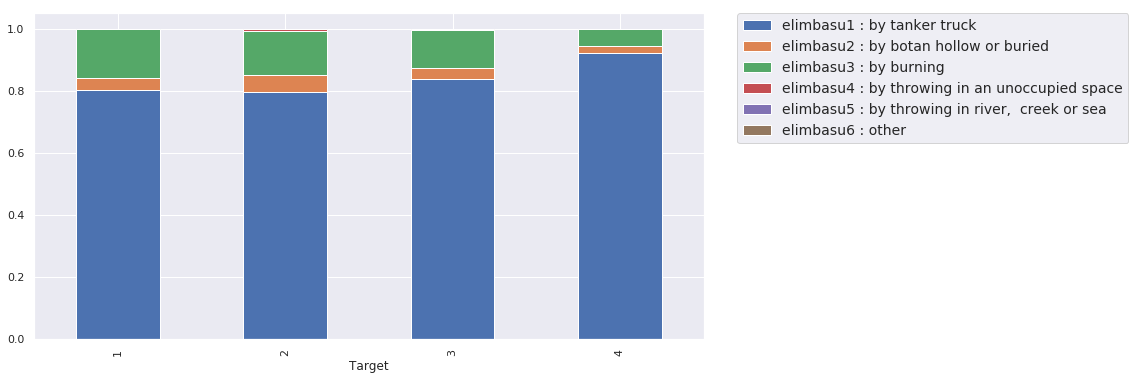

In [28]:
plot_breakdowns(desc)

### Wall quality

In [29]:
desc = get_columns_about('walls are', 'blah', {'=1 if walls are ':''})
desc

{'epared1': 'bad', 'epared2': 'regular', 'epared3': 'good'}

,epared1 : bad,epared2 : regular,epared3 : good
Target,,,
1,0.234234,0.459459,0.306306
2,0.199095,0.423077,0.377828
3,0.138211,0.368564,0.493225
4,0.059847,0.256266,0.683887


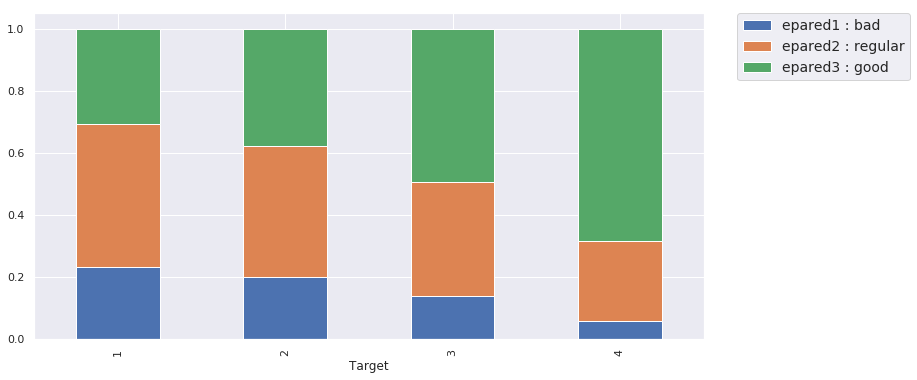

In [30]:
plot_breakdowns(desc)

### Roof quality

In [31]:
desc = get_columns_about('roof are', 'blah', {'=1 if roof are ':''})
desc

{'etecho1': 'bad', 'etecho2': 'regular', 'etecho3': 'good'}

,etecho1 : bad,etecho2 : regular,etecho3 : good
Target,,,
1,0.297297,0.382883,0.319820
2,0.226244,0.359729,0.414027
3,0.173442,0.363144,0.463415
4,0.084910,0.234271,0.680818


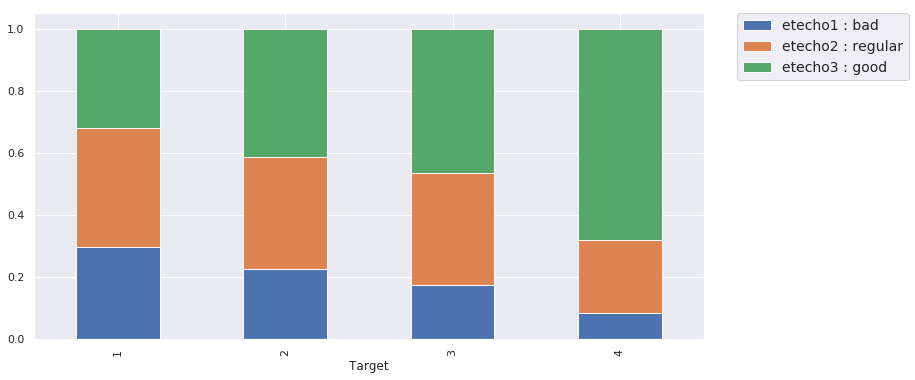

In [32]:
plot_breakdowns(desc)

### Floor quality

In [33]:
desc = get_columns_about('floor are', 'blah', {'=1 if walls are ':''})
desc

{'eviv1': '=1 if floor are bad',
 'eviv2': '=1 if floor are regular',
 'eviv3': '=1 if floor are good'}

,eviv1 : =1 if floor are bad,eviv2 : =1 if floor are regular,eviv3 : =1 if floor are good
Target,,,
1,0.207207,0.414414,0.378378
2,0.217195,0.341629,0.441176
3,0.119241,0.322493,0.558266
4,0.052685,0.193862,0.753453


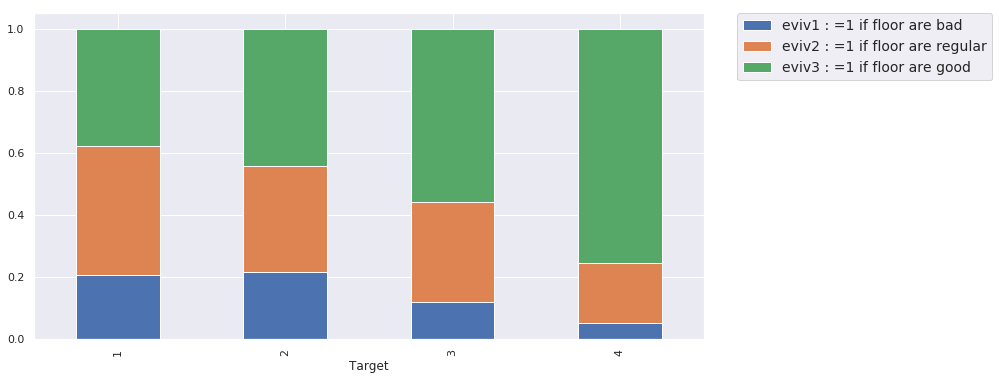

In [34]:
plot_breakdowns(desc)